# Lab01 Решение

## Задача

По имеющимся данным о рейтингах фильмов (MovieLens: 100 000 рейтингов) посчитать агрегированную статистику по ним.

In [1]:
import os
import sys

os.environ["PYSPARK_SUBMIT_ARGS"]='--num-executors 3 pyspark-shell'
os.environ["PYSPARK_PYTHON"]='/opt/anaconda/envs/bd9/bin/python'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.7-src.zip'))
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.5
      /_/

Using Python version 3.6.5 (default, Apr 29 2018 16:14:56)
SparkSession available as 'spark'.


In [2]:
sc

<SparkContext master=yarn appName=pyspark-shell>

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Loading ratings data

In [4]:
ratings_src = sc.textFile("/labs/laba01/ml-100k/u.data")

ratings_src.first()

'196\t242\t3\t881250949'

In [5]:
ratings_src.count()

100000

In [6]:
ratings_src.getNumPartitions()

2

In [9]:
ratings_src = ratings_src.repartition(3)

In [10]:
ratings_src.getNumPartitions()

3

In [11]:
# 0: user id | 1: item id | 2: rating | 3: timestamp
ratings_data = ratings_src.map(lambda r: r.split("\t"))
ratings_data.take(3)

[['113', '245', '3', '875325377'],
 ['749', '11', '5', '878848189'],
 ['84', '286', '5', '883449271']]

In [12]:
ratings = ratings_data.map(lambda r: int(r[2])).collect()

(array([ 6110., 11370., 27145., 34174., 21201.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

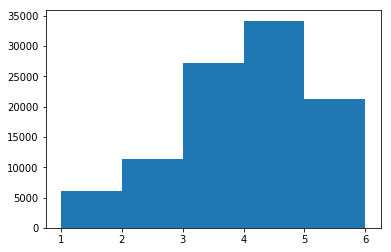

In [15]:
hist(ratings, bins=[1,2,3,4,5,6])

In [16]:
ratings_map = ratings_data.map(lambda r: (r[1], int(r[2])))

In [17]:
#item_id, rating
ratings_map.first()

('100', 4)

# Lab01

#### Для выданного id фильма:

#### 1. Построить распределения оценок. Получится таблица, где в первом столбце стоят значения оценки (1, 2, 3, 4, 5), а во втором количество человек, поставивших соответствующую оценку - поле “hist_film”

In [18]:
#personal data movie id
my_id = 269

In [19]:
movie_data_src = sc.textFile("/labs/laba01/ml-100k/u.item")
movie_data_src.first()

'1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0'

In [20]:
movie_data = movie_data_src.map(lambda line: line.split("|"))
my_film = movie_data.filter(lambda x: x[0] == str(my_id))
my_film.take(1)

[['269',
  'Full Monty, The (1997)',
  '01-Jan-1997',
  '',
  'http://us.imdb.com/M/title-exact?Full+Monty%2C+The+(1997)',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0']]

In [21]:
hist_film_kv_f = ratings_data.filter(lambda x: (x[1] == str(my_id)))
hist_film_kv_f.take(5)

[['114', '269', '4', '881256090'],
 ['147', '269', '4', '885593812'],
 ['111', '269', '5', '891679692'],
 ['25', '269', '4', '885851953'],
 ['23', '269', '5', '877817151']]

In [22]:
hist_film_kv_f.count()

315

In [25]:
hist_film_kv_m = hist_film_kv_f.map(lambda x: (x[2], 1))
hist_film_kv_m.take(5)

[('2', 1), ('4', 1), ('3', 1), ('4', 1), ('3', 1)]

In [26]:
hist_film_kv_r = hist_film_kv_m.reduceByKey(lambda x,y: x + y, 1)
hist_film_kv_r.take(5)

[('4', 125), ('3', 72), ('5', 97), ('2', 15), ('1', 6)]

In [27]:
hist_film_kv_r.getNumPartitions()

1

In [28]:
hist_film = [i[1] for i in hist_film_kv_r.sortByKey().collect()]
hist_film

[6, 15, 72, 125, 97]

#### 2. Чтобы понять какие оценки предпочитают ставить пользователи Movielens, постройте аналогичное предыдущему пункту 1 распределение оценок только уже для всего датасета - поле “hist_all”

In [29]:
hist_all_kv_m = ratings_data.map(lambda r: (r[2], 1))
hist_all_kv_r = hist_all_kv_m.reduceByKey(lambda x,y: x + y)
hist_all = [i[1] for i in hist_all_kv_r.sortByKey().collect()]
hist_all

[6110, 11370, 27145, 34174, 21201]

In [30]:
result_json={
            "hist_film": hist_film,
            "hist_all": hist_all
            }

In [31]:
import json
with open("lab01.json", "w") as j:
    json.dump(result_json, j)

In [ ]:
sc.stop()